<a href="https://colab.research.google.com/github/Kaliiiii/ML-Climate-Predictions/blob/main/ClimatePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Climate Predictor**

# Description
This is a machine learning project used to create a list of predictions of the average temperatures for 2024.

In [ ]:
!pip install meteostat

In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from meteostat import Stations
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

# Finding our Weather Station

In [ ]:
stations = Stations()
stations = stations.nearby(44.808147, -68.795013) # Exact coordinates of Bangor ME
station = stations.fetch(1)
print(station)

                                      name country region    wmo  icao  \
id                                                                       
72607  Bangor / Martells Mobile Home Court      US     ME  72607  KBGR   

       latitude  longitude  elevation          timezone hourly_start  \
id                                                                     
72607   44.8074   -68.8281       59.0  America/New_York   2010-08-01   

      hourly_end daily_start  daily_end monthly_start monthly_end     distance  
id                                                                              
72607 2024-09-18  1953-01-01 2024-12-30    1953-01-01  2022-01-01  2611.555842  


#Set train and test data

###Data from 1956 to 2012 will be used for training and 2013 to 2023 will be used to test the data.


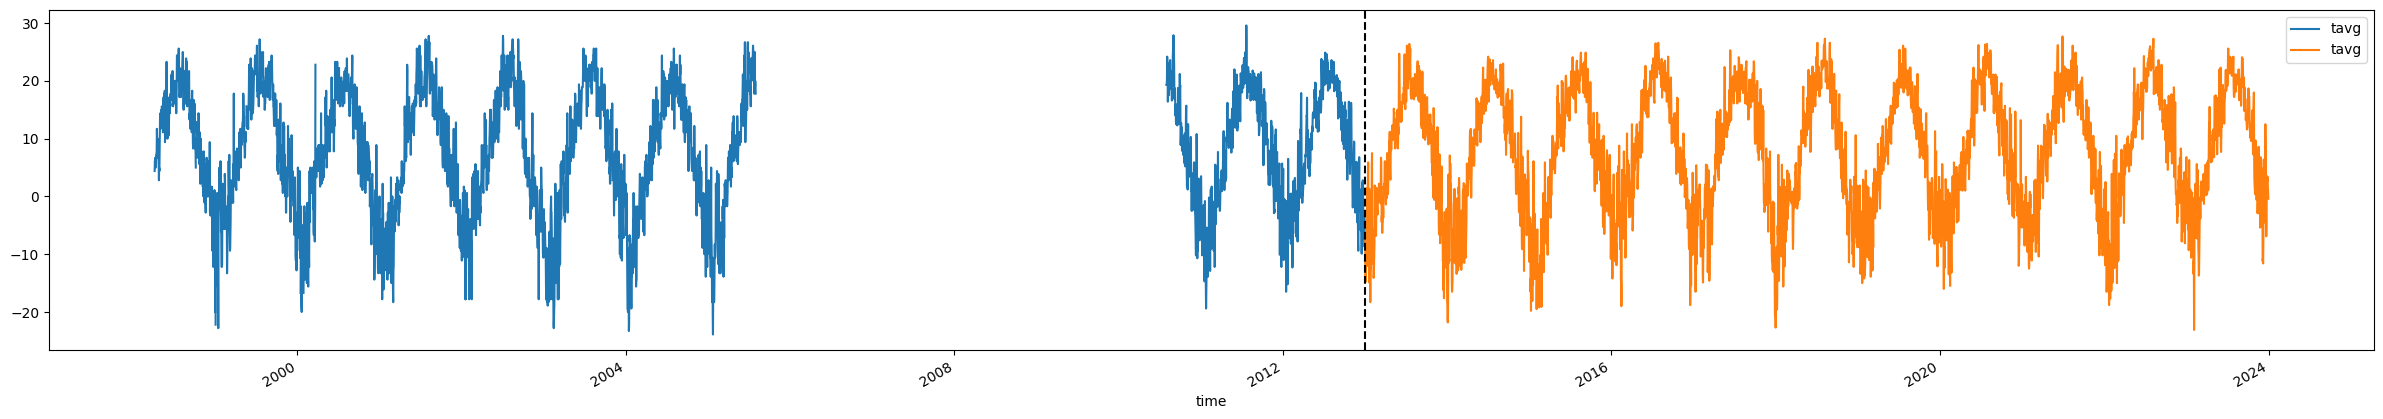

In [ ]:
# Set time period
train_start = datetime(1960, 1, 1)
train_end = datetime(2012, 12, 31)

test_start = datetime(2013, 1, 1)
test_end = datetime(2023, 12, 31)

# Utilizes 2023 data to get the create a set to predict data, it will be changed to 2024 and tavg values to NaN
pred_start = datetime(2023, 1, 1)
pred_end = datetime(2023, 12, 30)

# The station were fetched using the "station.nearby" funtion to identify a
# Station in Maine, USA. the coordinates used are fromt the results of that
# search.
maine = 72607 #Maine's station ID

#Fetch the data for the time period
train_data = Daily(maine, train_start, train_end)
train_data = train_data.fetch()

test_data = Daily(maine, test_start, test_end)
test_data = test_data.fetch()

pred_data = Daily(maine, pred_start, pred_end)
pred_data = pred_data.fetch()

# Plot line chart including average, minimum and maximum temperature
fig, ax = plt.subplots(figsize=(30, 5))
train_data.plot(ax =ax, y='tavg')
test_data.plot(ax=ax, y='tavg')
ax.axvline('01-01-2013', color='black', ls='--')

plt.show()

#Cleaning Data
We only want to look at average temp for now.

In [ ]:
#create time series features based on time series index
train_data = train_data.drop(columns = ['tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'])
test_data = test_data.drop(columns = ['tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'])
pred_data = pred_data.drop(columns = ['tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'])
train_data = train_data.dropna(subset=['tavg'])

#Making Prediction Data
Creating a data set to predict data onto using the XGBoost algorithm

In [ ]:
print(pred_data.columns)
pred_data['predDates'] = ''


for index, row in pred_data.iterrows():
  #print(index)
  pred_data.at[index, 'predDates'] = index + pd.DateOffset(years=1)
  pred_data.at[index, 'tavg'] = np.NaN
  #print(row['predDates'])

pred_data.set_index('predDates', inplace=True)

print(pred_data)

Index(['tavg'], dtype='object')
            tavg predDates
time                      
2023-01-01   6.8          
2023-01-02   2.1          
2023-01-03   2.2          
2023-01-04   3.0          
2023-01-05  -1.6          
...          ...       ...
2023-12-26   3.1          
2023-12-27   2.7          
2023-12-28   3.4          
2023-12-29   1.6          
2023-12-30   1.0          

[364 rows x 2 columns]
            tavg            predDates
time                                 
2023-01-01   NaN  2024-01-01 00:00:00
2023-01-02   NaN  2024-01-02 00:00:00
2023-01-03   NaN  2024-01-03 00:00:00
2023-01-04   NaN  2024-01-04 00:00:00
2023-01-05   NaN  2024-01-05 00:00:00
...          ...                  ...
2023-12-26   NaN  2024-12-26 00:00:00
2023-12-27   NaN  2024-12-27 00:00:00
2023-12-28   NaN  2024-12-28 00:00:00
2023-12-29   NaN  2024-12-29 00:00:00
2023-12-30   NaN  2024-12-30 00:00:00

[364 rows x 2 columns]
            tavg
predDates       
2024-01-01   NaN
2024-01-02   NaN
2024-01

#Creating Features and Understanding Data


In [ ]:
def create_features(dafr):
  dafr = dafr.copy()
  dafr['quarter']= dafr.index.quarter
  dafr['month']= dafr.index.month
  dafr['year']= dafr.index.year
  dafr['dayofyear']= dafr.index.dayofyear
  return dafr

train = create_features(train_data)
test = create_features(test_data)
pred = create_features(pred_data)

train = train.dropna(subset=["tavg"])
test = test.dropna(subset=["tavg"])

print(test)
print(train)
print(pred)

            tavg  quarter  month  year  dayofyear
time                                             
2013-01-01  -6.3        1      1  2013          1
2013-01-02 -14.8        1      1  2013          2
2013-01-03 -13.9        1      1  2013          3
2013-01-04  -8.9        1      1  2013          4
2013-01-05  -5.2        1      1  2013          5
...          ...      ...    ...   ...        ...
2023-12-27   2.7        4     12  2023        361
2023-12-28   3.4        4     12  2023        362
2023-12-29   1.6        4     12  2023        363
2023-12-30   1.0        4     12  2023        364
2023-12-31  -0.4        4     12  2023        365

[4017 rows x 5 columns]
            tavg  quarter  month  year  dayofyear
time                                             
1998-04-06   4.4        2      4  1998         96
1998-04-07   6.1        2      4  1998         97
1998-04-08   5.6        2      4  1998         98
1998-04-09   6.7        2      4  1998         99
1998-04-10   5.0        2

#Creating Model

In [ ]:
#Creating a copy of our data with the features

print(train.columns)
print(test.columns)

FEATURES = ['quarter', 'month', 'year', 'dayofyear']
TARGET = 'tavg'


Index(['tavg', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')
Index(['tavg', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')


In [ ]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

x_pred = pred[FEATURES]

In [ ]:
# Early stopping rounds determined through trial and error
reg = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=50,
                       learning_rate=0.1)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=20)

[0]	validation_0-rmse:9.69787	validation_1-rmse:9.80271
[20]	validation_0-rmse:3.76704	validation_1-rmse:4.94230
[40]	validation_0-rmse:3.31232	validation_1-rmse:4.83574
[60]	validation_0-rmse:3.14162	validation_1-rmse:4.85308
[80]	validation_0-rmse:3.03081	validation_1-rmse:4.88505
[85]	validation_0-rmse:3.00891	validation_1-rmse:4.88954


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

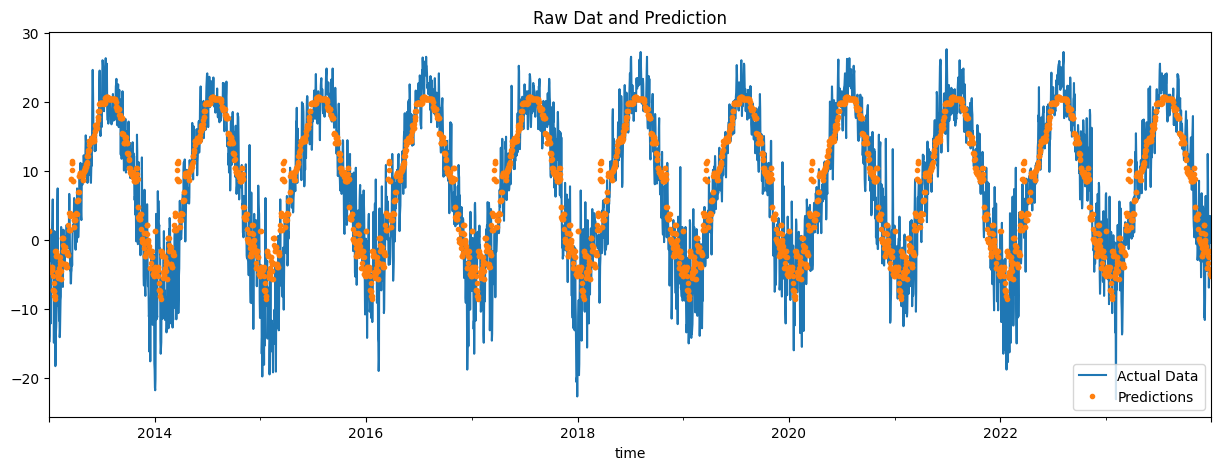

In [ ]:
test['prediction'] = reg.predict(x_test)
test_data = test_data.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = test_data[['tavg']].plot(figsize=(15, 5))
test_data['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

#Forcasting

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
print(fi)

           importance
quarter      0.034945
month        0.113543
year         0.040820
dayofyear    0.810692


Feature Importance indicates that dayofyear is the most important feature in average temperature predicting.

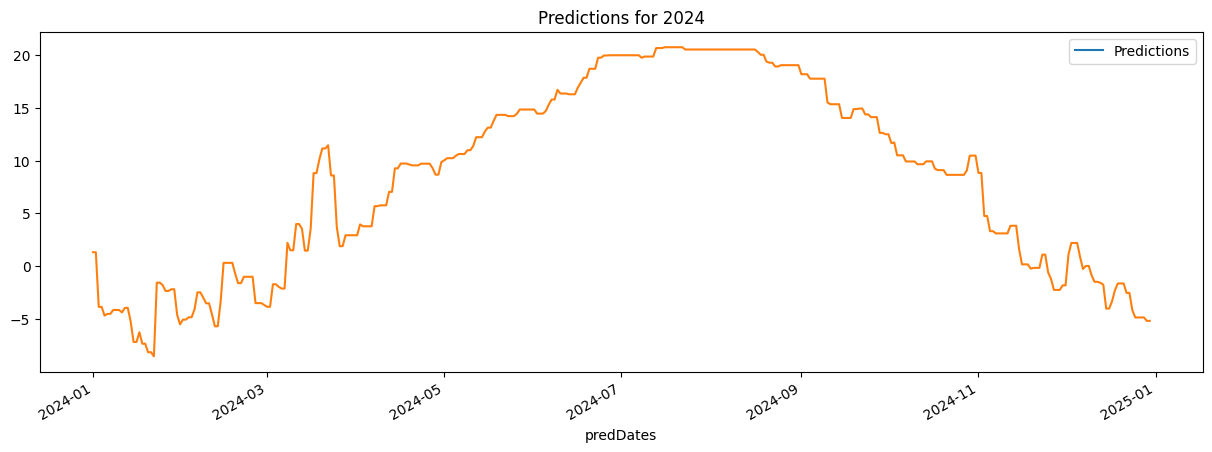

In [ ]:
pred['prediction'] = reg.predict(x_pred)

pred_data = pred_data.merge(pred['prediction'], how='left', left_index=True, right_index=True)
ax = pred_data[['tavg']].plot(figsize=(15, 5))
pred_data['prediction'].plot(ax=ax, style='-')
plt.legend(['Predictions'])
ax.set_title('Predictions for 2024')
plt.show()
